## Analysis of Loan duration and late returns
This notebook is used to explore possible correlations between loan duration and late returns.

Initialization - read all borrowings from "borrowings" csv-file

In [26]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

input_file = Path('../data/processed/borrowings_2019_2025.csv')

data_frame = pd.read_csv(
    input_file,
    sep=';',
    quotechar='"',
    encoding='utf-8'
)

print(data_frame.shape)
data_frame.head()

(2407610, 16)


,issue_id,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Leihdauer,Anzahl_Verlängerungen,Verspätet,Tage_zu_spät,Sammlungszeichen/CCODE,Medientyp,Barcode,Titel,Autor,ISBN,Interessenkreis,Benutzerkategorie,Benutzer-Systemnummer
0,56563,2019-01-02 00:00:00,2019-01-24 13:23:23,22.0,0,Nein,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDA,26.0
1,56564,2019-01-02 00:00:00,2019-01-30 13:40:14,28.0,0,Nein,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPA,50.0
2,56565,2019-01-02 00:00:00,2019-03-06 07:09:36,63.0,1,Nein,0.0,esac,Sachbuch,18143906,Hamburg - Der besondere Stadtführer,NaN,9783831904525,NaN,MPA,50.0
3,56566,2019-01-02 00:00:00,2019-03-06 07:09:38,63.0,1,Nein,0.0,esac,Sachbuch,18184110,Hamburg <Dorling Kindersley>,"Bruschke, Gerhard",9783734205736,NaN,MPA,50.0
4,56567,2019-01-02 00:00:00,2019-03-06 07:09:31,63.0,1,Nein,0.0,esac,Sachbuch,17202121,Hamburg <Reise-Know-How>,"Fründt, Hans-Jürgen",9783831730735,NaN,MPA,50.0


## Overview
show the amount of borrowings per category

In [15]:
data_frame["Medientyp"].unique()
data_frame["Medientyp"].value_counts()

Medientyp
Kinder u. Jugendbuch           663197
Sachbuch                       332011
DVD                            247870
Belletristik                   237871
Kinder u. Jugend-CD            168296
Comic                          124836
Hörbuch                         56948
Musik-CD                        54010
Fremdsprachige Belletristik     24918
Tonie                           19386
Spiele                          18736
Zeitschriften                   12929
Konsolenspiel                    7429
Sprachkurse                      6745
Sonstiges                        6619
Blu-Ray                          3007
Kamishibai                       1671
Bibliothek der Dinge             1151
Lesehaus                          735
Makerboxen                        628
Bestellt über Medienwelten        569
CD-ROM                            419
Schlüssel                         254
Sach-CD                           110
Tablet                              9
Name: count, dtype: int64

In [16]:
book_categories = [
    "Sachbuch",
    "Belletristik",
    "Fremdsprachige Belletristik",
    "Kinder u. Jugendbuch",
    "Comic"
    "Zeitschriften"
]

books_frame = data_frame[
    data_frame["Medientyp"].isin(book_categories)
].reset_index(drop=True)

non_books_frame = data_frame[
    ~data_frame["Medientyp"].isin(book_categories)
].reset_index(drop=True)

all_data_frame = data_frame

print(f'=== Book Table ===')
print(books_frame.shape)
# display(books_frame.head())

print(f'=== Non Book Table ===')
print(non_books_frame.shape)
# display(non_books_frame.head())

=== Book Table ===
(1382833, 16)
=== Non Book Table ===
(1024777, 16)


## First look at Media Types in combination with late returns
Now we want to examine correlations between media types and borrowings that were returned late. As a first step, we analyze the percentage of items that were returned late. Rows without a media type are ignored.

In [18]:
# remove rows without media type
books_frame = books_frame.dropna(subset=["Medientyp"])
non_books_frame = non_books_frame.dropna(subset=["Medientyp"])
all_data_frame = all_data_frame.dropna(subset=["Medientyp"])

def getLateBorrowingsTable(input_data_frame):
    late_borrowings_per_type = []
    for media_type, media_type_group in input_data_frame.groupby("Medientyp"):
        amount_of_total_entries = len(media_type_group)
        amount_of_late_entries = (media_type_group["Verspätet"] == "Ja").sum()
        percent_late = amount_of_late_entries / amount_of_total_entries * 100

        late_borrowings_per_type.append({
         "Medientyp": media_type,
         "Anzahl_Ausleihen": amount_of_total_entries,
         "Anzahl_verspaetet": amount_of_late_entries,
         "Prozent_verspaetet": percent_late
        })

    # Ausgabe
    late_borrowings_per_type_table = (
        pd.DataFrame(late_borrowings_per_type)
        .sort_values("Prozent_verspaetet", ascending=False)
        .reset_index(drop=True)
    )
    return late_borrowings_per_type_table

late_books_table = getLateBorrowingsTable(books_frame)
late_non_books_table = getLateBorrowingsTable(non_books_frame)

display(late_books_table)
display(late_non_books_table)

,Medientyp,Anzahl_Ausleihen,Anzahl_verspaetet,Prozent_verspaetet
0,Sachbuch,332011,18236,5.492589
1,Fremdsprachige Belletristik,24918,1165,4.675335
2,Kinder u. Jugendbuch,663197,30868,4.654424
3,Comic,124836,3805,3.047999
4,Belletristik,237871,6322,2.657743


,Medientyp,Anzahl_Ausleihen,Anzahl_verspaetet,Prozent_verspaetet
0,Schlüssel,254,30,11.811024
1,Bibliothek der Dinge,1151,132,11.468288
2,Tablet,9,1,11.111111
3,Makerboxen,628,56,8.917197
4,Sprachkurse,6745,519,7.694589
5,Konsolenspiel,7429,501,6.743842
6,Blu-Ray,3007,180,5.986033
7,Sonstiges,6619,392,5.922345
8,DVD,247870,14433,5.822810
9,Kamishibai,1671,96,5.745063


## Cleanup
For the further analysis, uninteresting media types and media types with fewer than 1,000 entries are removed. This criteria can be adjusted here.

In [34]:
UNINTERESTING_TYPES = [
    "Sonstiges",
    "Lesehaus",
    "Bestellt über Medienwelten",
]
MIN_BORROWINGS = 1000


amount_of_entries_per_type = all_data_frame["Medientyp"].value_counts()
list_of_valid_types = amount_of_entries_per_type[amount_of_entries_per_type >= MIN_BORROWINGS].index
list_of_interesting_types = list_of_valid_types.difference(UNINTERESTING_TYPES)

all_data_frame = all_data_frame[all_data_frame["Medientyp"].isin(list_of_interesting_types)]
books_frame = books_frame[books_frame["Medientyp"].isin(list_of_interesting_types)]
non_books_frame = non_books_frame[non_books_frame["Medientyp"].isin(list_of_interesting_types)]


## Identifying Indicators for Late Returns

The next step is to find good indicators for late returns by analyzing loan duration characteristics and their relationship to overdue behavior across different media types. The table below summarizes key statistics per media type. (boxplots for visualization)

### Column Descriptions

- **mean**: Average loan duration (in days).
- **median**: Median loan duration
- **p75 / p90 / p95**: Upper quantiles of the loan duration distribution, describing long borrowing periods.
- **late_rate_percent**:  Share of borrowings returned late.
- **median_late**: Median loan duration for borrowings that were returned late. Indicates how long overdue items are typically kept.
- **median_on_time**: Median loan duration for borrowings returned on time. Baseline for regular borrowing behavior.
- **Delta_Median**: Difference between late and on-time median loan duration. Highlights whether longer borrowing durations are associated with late returns.


<Figure size 1000x600 with 0 Axes>

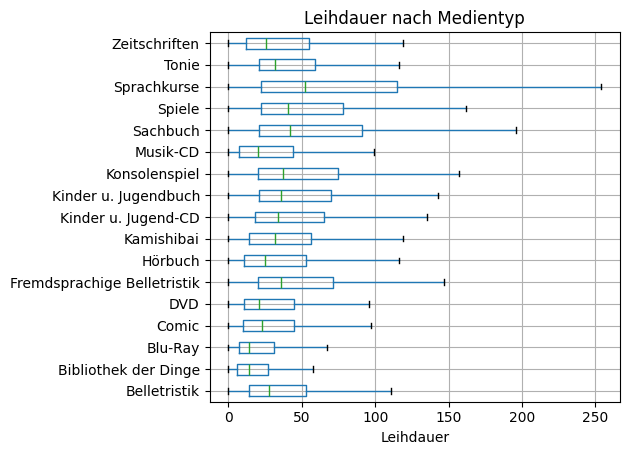

,Medientyp,mean,median,p75,p90,p95,late_rate_percent,median_late,median_on_time,Delta_Median
14,Sprachkurse,77.843318,52.0,115.0,188.0,227.0,7.694589,119.0,49.0,70.0
16,Zeitschriften,43.818219,26.0,55.0,108.0,161.0,3.449609,93.5,25.0,68.5
11,Musik-CD,37.719023,20.0,44.0,98.0,153.0,1.836697,84.0,19.0,65.0
12,Sachbuch,66.898923,42.0,91.0,167.0,203.0,5.492589,96.0,41.0,55.0
6,Hörbuch,41.736471,25.0,53.0,103.0,147.0,2.386388,68.0,24.0,44.0
5,Fremdsprachige Belletristik,55.617591,36.0,71.0,129.0,175.0,4.675335,78.0,35.0,43.0
8,Kinder u. Jugend-CD,51.205289,34.0,65.0,115.0,162.0,3.226458,67.0,33.0,34.0
3,Comic,35.849337,23.0,45.0,83.0,120.0,3.047999,55.0,22.0,33.0
10,Konsolenspiel,57.599045,37.0,75.0,144.0,185.0,6.743842,67.0,35.0,32.0
13,Spiele,59.712515,41.0,78.0,139.7,183.0,5.481426,70.0,39.0,31.0


In [55]:
leihdauer_stats = (
    all_data_frame
    .groupby("Medientyp")["Leihdauer"]
    .agg(
        mean="mean",
        median="median",
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
    )
    .reset_index()
)

late_rate = (
    all_data_frame
    .groupby("Medientyp")["Verspätet"]
    .apply(lambda x: (x == "Ja").mean() * 100)
    .rename("late_rate_percent")
)

leihdauer_by_late = (
    all_data_frame
    .groupby(["Medientyp", "Verspätet"])["Leihdauer"]
    .median()
    .unstack()
    .rename(columns={"Ja": "median_late", "Nein": "median_on_time"})
)

leihdauer_by_late["Delta_Median"] = (
        leihdauer_by_late["median_late"]
        - leihdauer_by_late["median_on_time"]
)

final_table = (
    leihdauer_stats
    .set_index("Medientyp")
    .join(late_rate)
    .join(leihdauer_by_late)
    .reset_index()
    .sort_values("Delta_Median", ascending=False)
)

order = final_table["Medientyp"].tolist()

plt.figure(figsize=(10, 6))
all_data_frame.boxplot(
    column="Leihdauer",
    by="Medientyp",
    vert=False,
    grid=True,
    showfliers=False
)
plt.suptitle("")
plt.title("Leihdauer nach Medientyp")
plt.xlabel("Leihdauer")
plt.ylabel("")
plt.tight_layout()
plt.show()

display(final_table)


## Takeaways
- across all media categories, late returns are associated with longer loan durations
- in some categories extended usage periods can be considered as a relevant risk signal for late returns (categories with high "Delta_Median")
- in categories with low "Delta_Median", this relationship is much less pronounced, suggesting that late returns there are driven by different underlying factors.

So there is a correlation between loan duration and late returns. In some categories its more pronounced.
To show this correlation we can look at the following plot (over all categories)

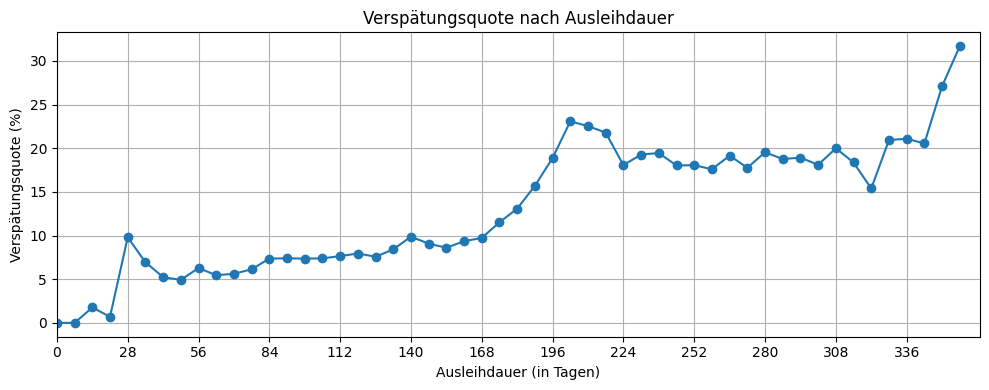

In [52]:
all_data_copy = all_data_frame.copy()

all_data_copy["late"] = (all_data_copy["Verspätet"] == "Ja").astype(int)

# bins of 7 days (for loan duration)
all_data_copy["duration_bin_7d"] = pd.cut(
    all_data_copy["Leihdauer"],
    bins=range(0, 366, 7),
    include_lowest=True
)

# Verspätungsquote pro Bin
late_rate_7d = (
    all_data_copy.groupby("duration_bin_7d", observed=False)["late"]
    .mean()
    * 100
)

# Plot
x_vals = [interval.left for interval in late_rate_7d.index]
plt.figure(figsize=(10, 4))
plt.plot(x_vals, late_rate_7d.values, marker="o")

plt.xlabel("Ausleihdauer (in Tagen)")
plt.ylabel("Verspätungsquote (%)")
plt.title("Verspätungsquote nach Ausleihdauer")

plt.xticks(np.arange(0, max(x_vals) + 1, 28))
plt.xlim(0, 365)

plt.grid(True)
plt.tight_layout()
plt.show()


We can see that a longer loan duration leads to a higher delay rate. In some media types, this correlation is more pronounced (as shown in the table)

## Analysis of extensions and late returns
Another interesting data point are the amount of the extensions. Is there a correlation to late returns?
First we look at the basic

<Figure size 1000x600 with 0 Axes>

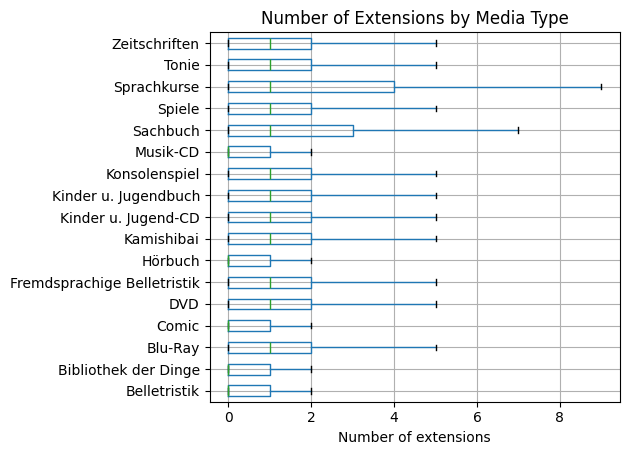

,Medientyp,n_loans,mean_extensions,median_extensions,max_extensions,pct_with_extension,late_rate
0,Belletristik,237871,1.041073,0.0,32,0.472079,0.026577
1,Bibliothek der Dinge,1151,0.953953,0.0,7,0.365769,0.114683
2,Blu-Ray,3007,1.394746,1.0,9,0.523445,0.059860
3,Comic,124836,0.921489,0.0,11,0.439641,0.030480
4,DVD,247870,1.521152,1.0,29,0.560842,0.058228
5,Fremdsprachige Belletristik,24918,1.415884,1.0,19,0.574725,0.046753
6,Hörbuch,56948,1.034856,0.0,10,0.447320,0.023864
7,Kamishibai,1671,1.087373,1.0,11,0.506284,0.057451
8,Kinder u. Jugend-CD,168296,1.226226,1.0,24,0.538278,0.032265
9,Kinder u. Jugendbuch,663197,1.285615,1.0,24,0.556645,0.046544


In [68]:
overview_table = (
    all_data_frame
    .assign(
        late = all_data_frame["Verspätet"] == "Ja",
        has_extension = all_data_frame["Anzahl_Verlängerungen"] > 0
    )
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),
        mean_extensions=("Anzahl_Verlängerungen", "mean"),
        median_extensions=("Anzahl_Verlängerungen", "median"),
        max_extensions=("Anzahl_Verlängerungen", "max"),
        pct_with_extension=("has_extension", "mean"),
        late_rate=("late", "mean"),
    )
    .reset_index()
)

plt.figure(figsize=(10, 6))

all_data_frame.boxplot(
    column="Anzahl_Verlängerungen",
    by="Medientyp",
    vert=False,
    showfliers=False
)

plt.suptitle("")
plt.title("Number of Extensions by Media Type")
plt.xlabel("Number of extensions")
plt.ylabel("")
plt.tight_layout()
plt.show()


display(overview_table)

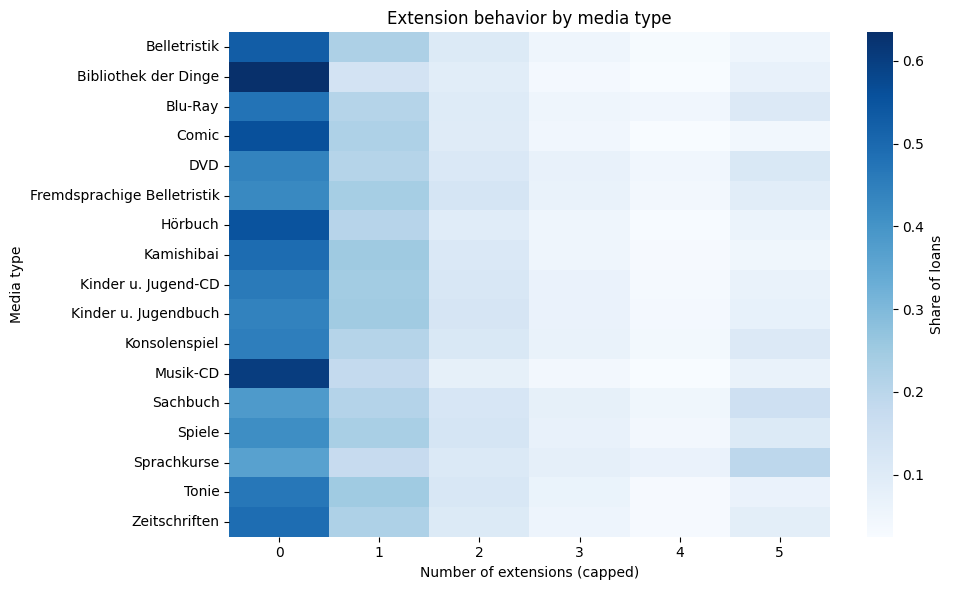

'0.13.2'

In [72]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    dist,
    cmap="Blues",
    annot=False,
    cbar_kws={"label": "Share of loans"}
)

plt.xlabel("Number of extensions (capped)")
plt.ylabel("Media type")
plt.title("Extension behavior by media type")
plt.tight_layout()
plt.show()

sns.__version__


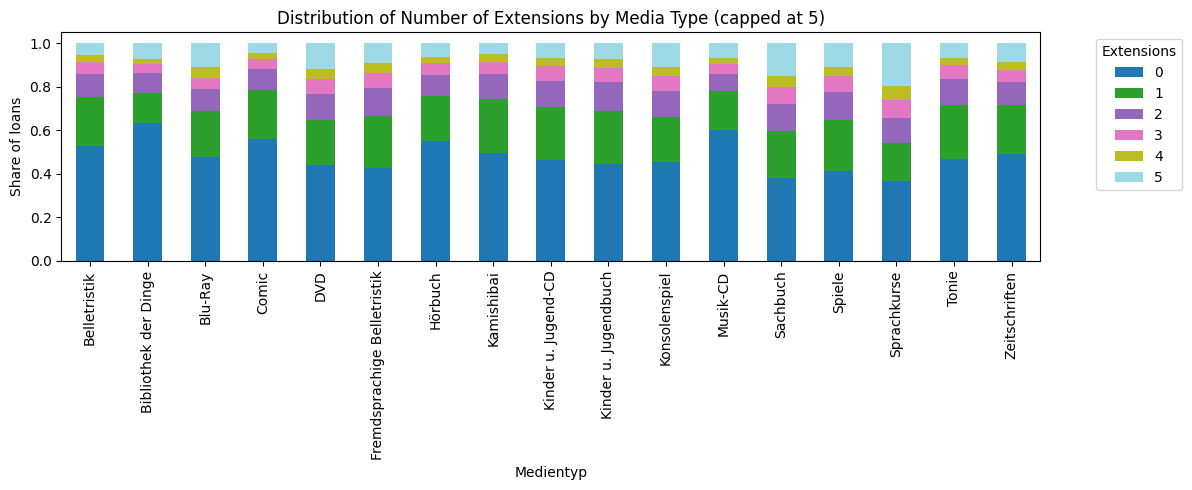

In [69]:
df_ext = all_data_frame.copy()
df_ext["ext_capped"] = df_ext["Anzahl_Verlängerungen"].clip(upper=5)

dist = (
    df_ext
    .groupby(["Medientyp", "ext_capped"])
    .size()
    .unstack(fill_value=0)
)

# convert to proportions
dist = dist.div(dist.sum(axis=1), axis=0)

dist.plot(
    kind="bar",
    stacked=True,
    figsize=(12,5),
    colormap="tab20"
)

plt.ylabel("Share of loans")
plt.title("Distribution of Number of Extensions by Media Type (capped at 5)")
plt.legend(title="Extensions", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


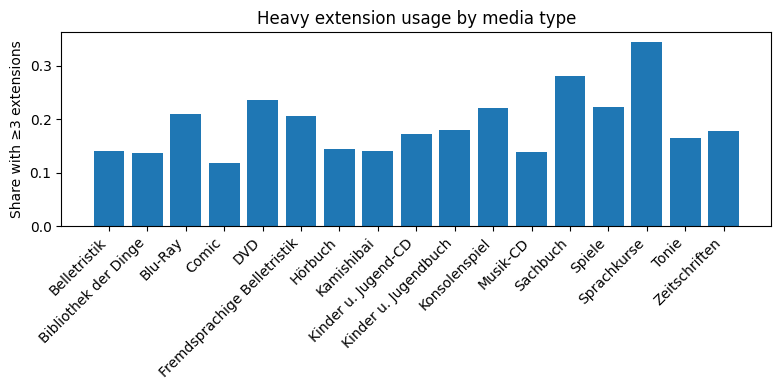

In [70]:
pct_many_extensions = (
    all_data_frame
    .assign(many_ext = all_data_frame["Anzahl_Verlängerungen"] >= 3)
    .groupby("Medientyp")["many_ext"]
    .mean()
    .rename("pct_ext_3plus")
    .reset_index()
)
plt.figure(figsize=(8,4))
plt.bar(pct_many_extensions["Medientyp"],
        pct_many_extensions["pct_ext_3plus"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Share with ≥3 extensions")
plt.title("Heavy extension usage by media type")
plt.tight_layout()
plt.show()



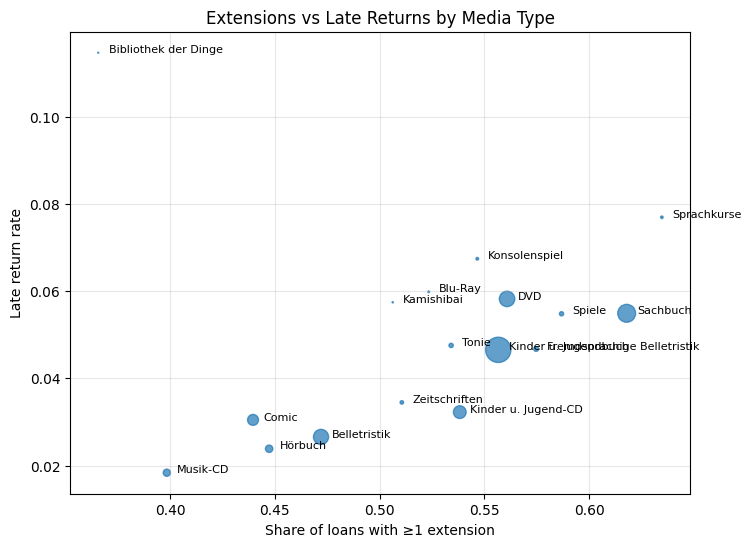

In [66]:
plt.figure(figsize=(8,6))
plt.scatter(
    overview_table["pct_with_extension"],
    overview_table["late_rate"],
    s=overview_table["n_loans"] / 2000,  # size ~ sample size
    alpha=0.7
)

for _, row in overview_table.iterrows():
    plt.text(
        row["pct_with_extension"] + 0.005,
        row["late_rate"],
        row["Medientyp"],
        fontsize=8
    )

plt.xlabel("Share of loans with ≥1 extension")
plt.ylabel("Late return rate")
plt.title("Extensions vs Late Returns by Media Type")
plt.grid(True, alpha=0.3)
plt.show()


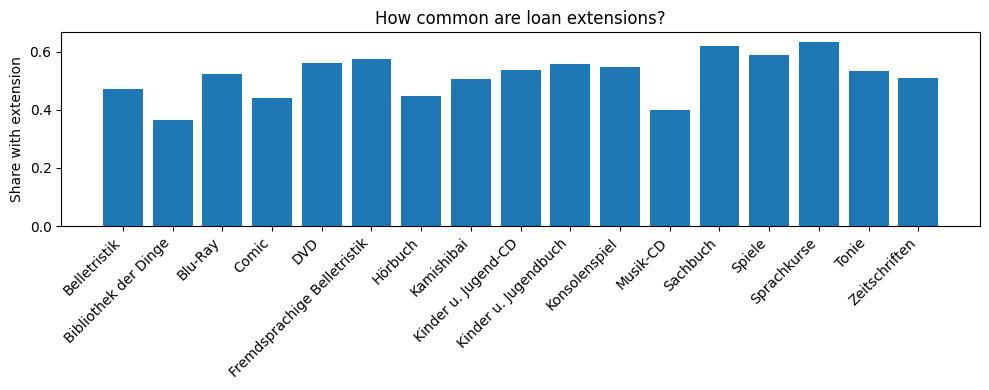

In [64]:
plt.figure(figsize=(10,4))
plt.bar(
    overview_table["Medientyp"],
    overview_table["pct_with_extension"]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Share with extension")
plt.title("How common are loan extensions?")
plt.tight_layout()
plt.show()


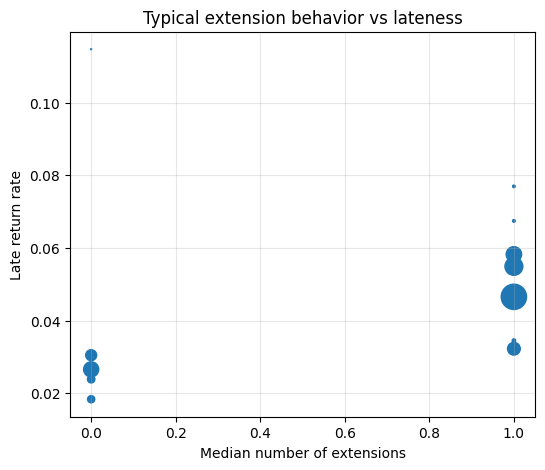

In [65]:
plt.figure(figsize=(6,5))
plt.scatter(
    overview_table["median_extensions"],
    overview_table["late_rate"],
    s=overview_table["n_loans"] / 2000
)
plt.xlabel("Median number of extensions")
plt.ylabel("Late return rate")
plt.title("Typical extension behavior vs lateness")
plt.grid(True, alpha=0.3)
plt.show()
